# Burst class for MINBAR

This notebook illustrates the use of a burst class for MINBAR and KEPLER models, including model-observation comparisons.  

The class definitions and related functions in the file burstclass.py, which can be imported as shown. First we define an observed burst, as well as a model burst, and then compare one to the other. You can get more information about the classes by using

    help (ObservedBurst)
    help (KeplerBurst)

Here we demonstrate the usage of the class. First we define an `ObservedBurst` using data read in from an example provided in the burst reference library described in [Galloway et al. (2017)](http://adsabs.harvard.edu/abs/2017arXiv170307485G) and available at http://burst.sci.monash.edu/reference. 

You may need to modify the path below depending upon where you have the lightcurve files on your system

4.177 h 0.01 h
1.1259999999999999e-06 erg / (cm2 s) 1.6e-08 erg / (cm2 s)
1.787 0.003


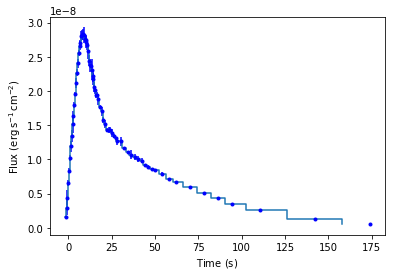

In [1]:
from burstclass import *

# Read in an observed burst

b = ObservedBurst('gs1826-24_4.177h.dat',path='../../burst/reference/')

# Show the recurrence time and other parameters, added from the .tex table

print (b.tdel,b.tdel_err)
print (b.fluen,b.fluen_err)
print (b.cbol,b.cbol_err)

# Here the plot method is inherited from the daughter class
# but doesn't work yet for the model burst class (because of the flux issue)

% matplotlib inline

# The plot is pretty basic for now

b.plot()

Next we define a model burst, in this case a KEPLER simulation described in [Lampe et al. (2016)](http://adsabs.harvard.edu/abs/2016ApJ...819...46L) and available at http://burst.sci.monash.edu/kepler

25 3.390000104904175 h 0.07999999821186066 h 0.082


-672.31586593257896

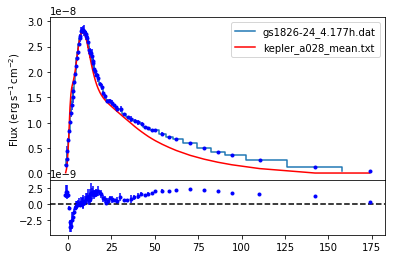

In [2]:
# Now also define a model burst. Note the difference in syntax

c = KeplerBurst(run_id='a028',path='../../burst/reference')

# Show some of the class attributs, including the corrseponding table row;
# recurrence time and error; and the accretion rate
# Note that the plot method doesn't work yet

print (c.row,c.tdel,c.tdel_err,c.Lacc)

# Here we try to do a simple single-epoch comparison

#print (c.flux(6.*u.kpc))
b.compare(c,[6.1*u.kpc,60.*u.degree,1.28,-6.5*u.s],plot=True,subplot=False)

We can also read in bursts that are *not* part of the Lampe et al. KEPLER sample, but we need to provide the basic info when initialising the class

816.33289078722692

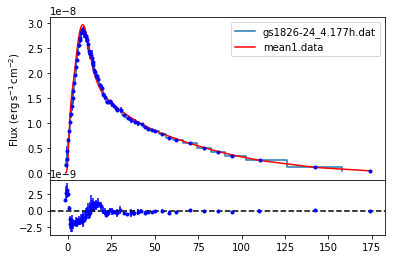

In [3]:
# Assumed redshift for calculating the recurrence times of the models;
# need to revert back to the recurrence time in the NS frame

opz = 1.259

# Note the specification of the filename instead, and also a different path

c_loZ=KeplerBurst(filename='mean1.data',path='kepler',
                  lAcc=0.1164,Z=0.005,H=0.7,
                  tdel=4.06/opz,tdel_err=0.17/opz,
                  xi=1.12, g = 1.858e+14*u.cm/u.s**2, R_NS=11.2*u.km)

b.compare(c_loZ,[6.7*u.kpc,60.*u.degree,1.28,-6.5*u.s],plot=True,subplot=False)

# Multiple burst comparisons

Here we demonstrate reading in multiple observed bursts, and matching them (as best as is possible) to the model bursts

In [4]:
# Assemble the observed bursts for GS 1826-24

path='../../burst/reference/'
b1 = ObservedBurst('gs1826-24_3.530h.dat',path=path)
b2 = ObservedBurst('gs1826-24_4.177h.dat',path=path)
b3 = ObservedBurst('gs1826-24_5.14h.dat',path=path)
obs = (b1,b2,b3)

# Calculate "target" ratios of mdot relative to b2; we want to find simulated
# bursts that have as close as possible the ratio of accretion rates,
# as do the observed bursts

t1 = b1.mdot/b2.mdot
t3 = b3.mdot/b2.mdot
print ("Mdot ratio targets: ",t1,t3)

# Define the model bursts. For the 4.177h burst, we already have a reasonable match with a028. 
# So need to get corresponding matches for the other two bursts

m2 = KeplerBurst(run_id='a028',path=path)

# Get the rows that match the same conditions for H-fraction and metallicity

same = np.where((m2.data['H'] == m2.data[m2.row]['H']) 
                & (m2.data['Z'] == m2.data[m2.row]['Z']))[0]
# print (same)

# And finally find the model with the closest ratio of accretion rates to our targets

acc_ratio = m2.data['Lacc']/m2.data[m2.row]['Lacc']
best1 = np.argmin(abs(acc_ratio[same]-t1))
print (same[best1], m2.data['Lacc'][same][best1],acc_ratio[same][best1], t1, m2.data['model'][same][best1])

best3 = np.argmin(abs(acc_ratio[same]-t3))
print (same[best3], m2.data['Lacc'][same][best3],acc_ratio[same][best3], t3, m2.data['model'][same][best3])

# According to this code, the best choice of model for m1 is a005, which has a Lacc of 0.1 (confirmed)
# Similarly, for m3, the best choice is a019

m1 = KeplerBurst(run_id='a005',path=path)
m3 = KeplerBurst(run_id='a019',path=path)

# And finally assemble the model burst tuple

models = (m1, m2, m3)

Mdot ratio targets:  1.1502890173410405 0.7413294797687862
2 0.1 1.21951 1.1502890173410405 a005
16 0.067 0.817073 0.7413294797687862 a019


In [5]:
# Now the real test, with a multiple burst comparison
# Need an offset parameter for each burst, so build the parameter array
# dynamically here

params = [6.09*u.kpc,60.*u.degree,1.28]
for i in range(len(obs)):
    params.append(-6.5*u.s)

lh3 = lhoodClass(params,obs,models)
print ('Combined likelihood for all three models is ',lh3)

Combined likelihood for all three models is  -7968.131094960712


Since we've come this far, we might as well try to run emcee with the new lhoodClass routine. We define the parameters and initialise the walkers in a small ball around those values. Then we run the chains (for a modest numer of steps, at least initially)

In [5]:
import emcee

# emcee doesn't like parameters with units, so let's omit them for now
# I've tweaked lhoodClass to make sure they are re-applied prior to the
# likelihood calculation
# Need an offset parameter for each burst, so build the parameter array
# dynamically here

params = [6.09,60.,1.28]
for i in range(len(obs)):
    params.append(-6.5)

ndim, nwalkers = len(params), 200
pos = [params*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

# Set up the walkers

# pos = []
# for i in range(nwalkers):
#     _params = [x*(1.+1e-4*np.random.randn()) for x in params]
#     pos.append(_params)
    
sampler = emcee.EnsembleSampler(nwalkers, ndim, lhoodClass, 
                                args=(obs,models))

# The example below is just for a quick test; if you were doing this properly
# you would run for many many steps

print ("Running sampler...")
# %timeit -n 1 -r 1 pos_new, lnprob, rstate = sampler.run_mcmc(pos,20)
# 1 loop, best of 1: 2min 18s per loop (100 walkers)
pos_new, lnprob, rstate = sampler.run_mcmc(pos,20)

# ~8hr run
# pos_new, lnprob, rstate = sampler.run_mcmc(pos,1000)

print ("...done.")

Running sampler...
...done.


Now visualise the results. Here's an example using ChainConsumer

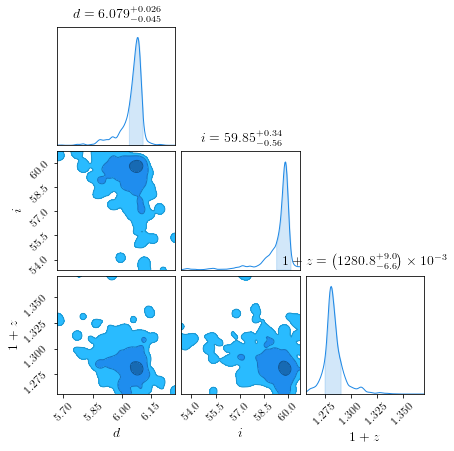

In [6]:
c = plot_contours(sampler)

# Nice plot of the walks

# c.plot_walks()

We also want to visualise the model comparisons, for the best example (highest likelihood) set achieved by the code.

This currently doesn't work because of the conflicting gridspec calls for the single and multiple plot. To be fixed

Got parameter set for plotting:  [<Quantity 6.210370030260364 kpc>, <Quantity 53.33372525927557 deg>, 1.3211808069549582, <Quantity -6.844547417757502 s>, <Quantity -6.745823223347206 s>, <Quantity -6.469173408297157 s>]


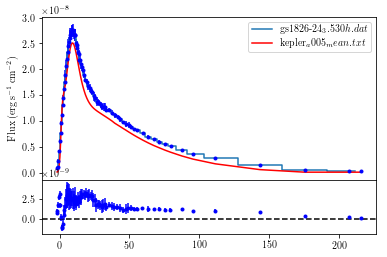

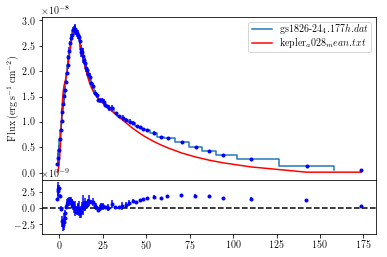

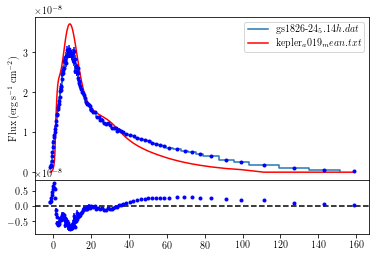

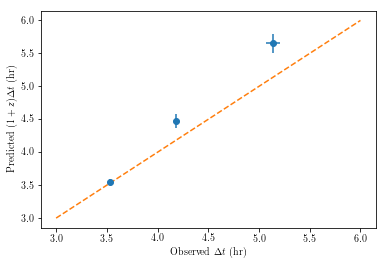

In [7]:
plot_comparison(obs,models,sampler=sampler)